# Plot total feedbacks for multiple experiments

## 50-year rolling Control ref 

## 150-year window for linear regression

Assuming radiative kernels already calculated in /tigress/mvchung/ANALYSIS/Solar_NEW/feedbacks_MVC/1_R3k_GFDL_Solar_50yrCTRLref.ipynb

In [1]:
import numpy as np
import xarray as xr 
import matplotlib.pyplot as plt

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import subprocess 
import time
from scipy import stats
sstart_time0 = time.time()
import netCDF4

# plot style
plt.style.use('/tigress/mvchung/ANALYSIS/func/paper.mplstyle')
from tqdm.notebook import tqdm

In [2]:
# rh decomposition
def rh_decomposition(ds_rk):
    dR_temp_gm = (ds_rk['dR_Ta_rh_lw_gm'] + ds_rk['dR_Ta_rh_sw_gm'] + ds_rk['dR_ts_gm']).groupby('time.year').mean('time')
    dR_lr_gm   = (ds_rk['dR_LR_rh_lw_gm'] + ds_rk['dR_LR_rh_sw_gm']  ).groupby('time.year').mean('time')
    dR_clou_gm = (ds_rk['dR_cloud_lw_gm']  + ds_rk['dR_cloud_sw_gm'] ).groupby('time.year').mean('time')
    dR_wv_gm   = (ds_rk['dR_rh_lw_gm']     + ds_rk['dR_rh_sw_gm']    ).groupby('time.year').mean('time')
    dR_albe_gm = ds_rk['dR_alb_gm'].groupby('time.year').mean('time')
    dts_gm     = ds_rk['dts_gm']   .groupby('time.year').mean('time')
    
    return dR_temp_gm, dR_lr_gm, dR_clou_gm, dR_wv_gm, dR_albe_gm, dts_gm

def conventional_decomposition(ds_rk):
    dR_temp_gm = (ds_rk['dR_ta_gm']        + ds_rk['dR_ts_gm']       ).groupby('time.year').mean('time')
    dR_lr_gm   = ds_rk['dR_lr_gm'].groupby('time.year').mean('time')
    dR_clou_gm = (ds_rk['dR_cloud_lw_gm']  + ds_rk['dR_cloud_sw_gm'] ).groupby('time.year').mean('time')
    dR_wv_gm   = (ds_rk['dR_wv_lw_gm']     + ds_rk['dR_wv_sw_gm']    ).groupby('time.year').mean('time')
    dR_albe_gm = ds_rk['dR_alb_gm'].groupby('time.year').mean('time')
    dts_gm     = ds_rk['dts_gm']   .groupby('time.year').mean('time')
    
    return dR_temp_gm, dR_lr_gm, dR_clou_gm, dR_wv_gm, dR_albe_gm, dts_gm

def plot_decomposition(ds_rk, ax1, decomp_type='rh'):
    if decomp_type == 'rh':
        dR_temp_gm, dR_lr_gm, dR_clou_gm, dR_wv_gm, dR_albe_gm, dts_gm = rh_decomposition(ds_rk)
    elif decomp_type == 'conventional':
        dR_temp_gm, dR_lr_gm, dR_clou_gm, dR_wv_gm, dR_albe_gm, dts_gm = conventional_decomposition(ds_rk)
    
    ax1.plot(dts_gm,dR_temp_gm/5,'.',label='dR_Temp/5')
    ax1.plot(dts_gm,dR_clou_gm,'.',label='dR_Cloud')
    ax1.plot(dts_gm,dR_albe_gm,'.',label='dR_Albe')
    if decomp_type == 'rh':
        ax1.plot(dts_gm,dR_wv_gm,'.',label='dR_RH')
    elif decomp_type == 'conventional':
        ax1.plot(dts_gm,dR_wv_gm,'.',label='dR_WV')
    ax1.set_xlabel('dTs')
    ax1.axhline(0,color='k',linewidth=1,zorder=0)
    ax1.grid(linestyle='--')

In [3]:
# calculate climate feedbacks
def calc_feedbacks(dR_temp_gm, dR_lr_gm, dR_clou_gm, dR_wv_gm, dR_albe_gm, dts_gm, 
                   decomp_type='total', print_output=False):
    
    # regress the RR on to ts and the slope is the climate feedback
    if decomp_type == 'conventional':
        fb_name = ['Plank','LR','Cloud','WV','Albedo']
        dR_list = {
        'Plank':dR_temp_gm-dR_lr_gm,
        'LR':dR_lr_gm,
        'Cloud': dR_clou_gm,
        'WV':dR_wv_gm,
        'Albedo':dR_albe_gm
        }
    if decomp_type == 'rh':
        fb_name = ['Plank','LR','Cloud','RH','Albedo']
        dR_list = {
        'Plank':dR_temp_gm-dR_lr_gm,
        'LR':dR_lr_gm,
        'Cloud': dR_clou_gm,
        'RH':dR_wv_gm,
        'Albedo':dR_albe_gm
        }
    if 'albedo' in decomp_type:
        fb_name = ['Albedo','Non-Albedo']
        dR_list = {
        'Albedo':dR_albe_gm,
        'Non-Albedo':dR_temp_gm+dR_clou_gm+dR_wv_gm #-dR_lr_gm+dR_lr_gm
        }
    if 'total' in decomp_type:
        fb_name = ['Total']
        dR_list = {
        'Total':dR_albe_gm + dR_temp_gm+dR_clou_gm+dR_wv_gm #-dR_lr_gm+dR_lr_gm
        }
    
    slope_list = []
    for name in fb_name:

        fb = stats.linregress(dts_gm, dR_list[name]).slope    # do the linear regression with surface temperature change, feedback = slope
        if print_output == True:
            print(f'{name:6s}:{fb:5.2f} W/m2/K')
        
        my_dict = {f'{name:6s}': fb}
        slope_list.append(my_dict)
        
    return slope_list
        
def decomp_calc_feedbacks(ds_rk, decomp_type='total',print_output=False):
    # uses rh decomposition by default
    
    if decomp_type not in ['conventional','rh','albedo','total']:
        print('Error: please input valid decomposition type: conventional, rh, albedo')
    
    if decomp_type == 'conventional':
        dR_temp_gm, dR_lr_gm, dR_clou_gm, dR_wv_gm, dR_albe_gm, dts_gm = conventional_decomposition(ds_rk)
    
    elif decomp_type == 'rh':
        dR_temp_gm, dR_lr_gm, dR_clou_gm, dR_wv_gm, dR_albe_gm, dts_gm = rh_decomposition(ds_rk)
    
    elif 'albedo' in decomp_type: # use the rh decomposition
        dR_temp_gm, dR_lr_gm, dR_clou_gm, dR_wv_gm, dR_albe_gm, dts_gm = rh_decomposition(ds_rk)
        
    elif 'total' in decomp_type: # use the rh decomposition 
        dR_temp_gm, dR_lr_gm, dR_clou_gm, dR_wv_gm, dR_albe_gm, dts_gm = rh_decomposition(ds_rk)
    
    slope_list = calc_feedbacks(dR_temp_gm, dR_lr_gm, dR_clou_gm, dR_wv_gm, dR_albe_gm, dts_gm,
                               decomp_type, print_output)
    
    return slope_list

# compute with $n$-year rolling window

In [4]:
from tqdm.notebook import tqdm

In [5]:
# calculate the total feedbacks using a rolling window
# 3m 43s

def compute_total_feedback(FLOR_rk, window_size = 150):
    yrs_FLOR = list(range(0, int(FLOR_rk.time.size/12)))
    total_feedback_FLOR = np.empty((len(yrs_FLOR) - window_size + 1))

    import time
    start_time = time.time()
    
    for ii in range(len(yrs_FLOR) - window_size + 1):
        
        start = ii
        end = ii + window_size
        #window = years[start:end]
        
        data = FLOR_rk.isel(time=slice(start*12,end*12))    
        temp = decomp_calc_feedbacks(data, decomp_type='total')
        total_feedback_FLOR[ii] = temp[0]['Total ']

        if ii % 10 == 0:
            print(f'{ii/(len(yrs_FLOR) - window_size + 1)*100}% complete')
            elapsed_time = (time.time() - start_time) / 60
            print(f"Elapsed time: {elapsed_time:.2f} minutes")

    return yrs_FLOR, total_feedback_FLOR


In [6]:
# save to netcdf
def xr_ds_save(yrs_list,window_size,total_feedback,model,ref):
    # ref = '50yr' or '12month'
    
    t = yrs_list[int(window_size/2):-int(window_size/2)+1]
    t = [x + 101 for x in t] # make it model years

    ds = xr.Dataset(
        {f"total_feedback_{model}": (["year"], total_feedback)},
        coords={"year": t}
    )

    ds.to_netcdf(f'./total_feedback/total_feedback_{model}_{exp}%solar_ref_{ref}_window_{window_size}.nc')
    

## main section

In [7]:
# make sure the FLOR and CM2.1 feedbacks decomposition has already been done in 1_R3k_GFDL_Solar_50yrCTRLref.ipynb

In [8]:
def get_exps(model):
    if model == 'FLOR':
        exp = [
            'p6p0sol_CTL1860_tigercpu_intelmpi_18_576PE',
               'p4p0sol_CTL1860_tigercpu_intelmpi_18_576PE',
            'p2p0sol_CTL1860_tigercpu_intelmpi_18_576PE',
            'p1p0sol_CTL1860_tigercpu_intelmpi_18_576PE',
            'm1p0sol_CTL1860_tigercpu_intelmpi_18_576PE',
            'm2p0sol_CTL1860_tigercpu_intelmpi_18_576PE',
              'm4p0sol_CTL1860_tigercpu_intelmpi_18_576PE',
            'm6p0sol_CTL1860_tigercpu_intelmpi_18_576PE',
        ]
        CTRLexp = 'CTL1860_newdiag_tigercpu_intelmpi_18_576PE'
        
    elif model == 'CM2.1p1':
        exp = [
            'CTL1860_p6pctSolar_tigercpu_intelmpi_18_80PE',
            'CTL1860_p4pctSolar_tigercpu_intelmpi_18_80PE',
            'CTL1860_p2pctSolar_tigercpu_intelmpi_18_80PE',
            'CTL1860_p1pctSolar_tigercpu_intelmpi_18_80PE',
            'CTL1860_m1pctSolar_tigercpu_intelmpi_18_80PE',
            'CTL1860_m2pctSolar_tigercpu_intelmpi_18_80PE',
              'CTL1860_m4pctSolar_tigercpu_intelmpi_18_80PE',
            'CTL1860_m6pctSolar_tigercpu_intelmpi_18_80PE',
        ]
        CTRLexp = 'CTL1860_tigercpu_intelmpi_18_80PE'

    return exp, CTRLexp

In [9]:
def exp_to_pctstring(exp_list):
    # Dictionary to map patterns to their corresponding percent strings
    pattern_map = {
        'p6': '+6', 'm6': '-6',
        'p4': '+4', 'm4': '-4',
        'p2': '+2', 'm2': '-2',
        'p1': '+1', 'm1': '-1'
    }
    
    # Result list to store mapped values
    result = []
    
    # Iterate through the input list
    for exp in exp_list:
        # Find the match for each item
        matched = None
        for pattern, pctstring in pattern_map.items():
            if pattern in exp:
                matched = pctstring
                break
        result.append(matched)  # Append the result (or None if no match)

    return result


In [10]:
def get_start_end_yrs_exp(model, exp_fullname):

    import re
    import os

    # Define the directory and the prefix
    directory = f'./{model}_regridded/'
    prefix = f'alb_sfc.{exp_fullname}.mon.'
    
    # Get a list of files that start with the prefix
    files = [f for f in os.listdir(directory) if f.startswith(prefix)]
    
    # Loop through the files and process those that start with the prefix
    for path in files:
        # Extract the numbers matching "xxxx-yyyy"
        match = re.search(r'\.(\d{4})-(\d{4})', path)
        if match:
            start_year, end_year = map(int, match.groups())
            # Optionally print results
            # print(f"Path: {path}")
            # print(f"Start Year: {start_year}, End Year: {end_year}")

            return start_year, end_year  # Return the first match found
        
        else:
            print(f"Path: {path} - No year range found")
    
    # If no match is found after looping through all files
    print("No valid year range found in any file")
    return None, None  # Return None if no valid range is found

#get_start_end_yrs_exp('FLOR','m6p0sol_CTL1860_tigercpu_intelmpi_18_576PE')

In [13]:
decomp_type =  'total' 
window_size = 150 # years
ref = '50yr'

models = ['FLOR','CM2.1p1']

for model in models:

    experiments, _ = get_exps(model)

    experiments_strings = exp_to_pctstring(experiments)
    
    for iexp in range(np.size(experiments)):
        
        exp = experiments_strings[iexp]
        exp_fullname = experiments[iexp]

        import os 
        
        file_path = f'./total_feedback/total_feedback_{model}_{exp}%solar_ref_{ref}_window_{window_size}.nc'
        print(file_path)
        
        if os.path.exists(file_path):  
            print(f'Already exists: {file_path}\n')
            
        else:
            
            files = f'./rk_decomp/rk.decomp.{model}.{exp}%solar.{ref}ref.*.nc'
            try:
                ds_rk = xr.open_mfdataset(files, combine="by_coords", parallel=True)
            except OSError as e:
                print('*****No feedback files exist. Need to run 1_R3k_GFDL_Solar_50yrCTRLref*****\n')
                continue

            ### make sure all the data is there
            start_year, end_year = int(ds_rk.time.dt.year[0]), int(ds_rk.time.dt.year[-1]) # get first and last year
            yr1, yr2 = get_start_end_yrs_exp(model,exp_fullname) # get first and last year of original data file
            
            # if first and last year do not match the original data files, skip
            if start_year != yr1 or end_year != yr2:
                print('****Time dimension mismatch; feedbacks incomplete. Need to finish running 1_R3k_GFDL_Solar_50yrCTRLref')
                print(f'Have: {start_year, end_year}')
                print(f'Need: {yr1, yr2}')
                continue
            
            else:  # proceed with calculation
                print('calculating...')
                yrs, total_feedback = compute_total_feedback(ds_rk, window_size = window_size)
                xr_ds_save(yrs,window_size,total_feedback,model,ref) # save the data
            

./total_feedback/total_feedback_FLOR_+6%solar_ref_50yr_window_150.nc
Already exists: ./total_feedback/total_feedback_FLOR_+6%solar_ref_50yr_window_150.nc

./total_feedback/total_feedback_FLOR_+4%solar_ref_50yr_window_150.nc
Already exists: ./total_feedback/total_feedback_FLOR_+4%solar_ref_50yr_window_150.nc

./total_feedback/total_feedback_FLOR_+2%solar_ref_50yr_window_150.nc
Already exists: ./total_feedback/total_feedback_FLOR_+2%solar_ref_50yr_window_150.nc

./total_feedback/total_feedback_FLOR_+1%solar_ref_50yr_window_150.nc
calculating...
0.0% complete
Elapsed time: 0.04 minutes
2.849002849002849% complete
Elapsed time: 0.48 minutes
5.698005698005698% complete
Elapsed time: 0.91 minutes
8.547008547008547% complete
Elapsed time: 1.36 minutes
11.396011396011396% complete
Elapsed time: 1.80 minutes
14.245014245014245% complete
Elapsed time: 2.24 minutes
17.094017094017094% complete
Elapsed time: 2.68 minutes
19.943019943019944% complete
Elapsed time: 3.12 minutes
22.79202279202279% co

# Plot the data if already generated

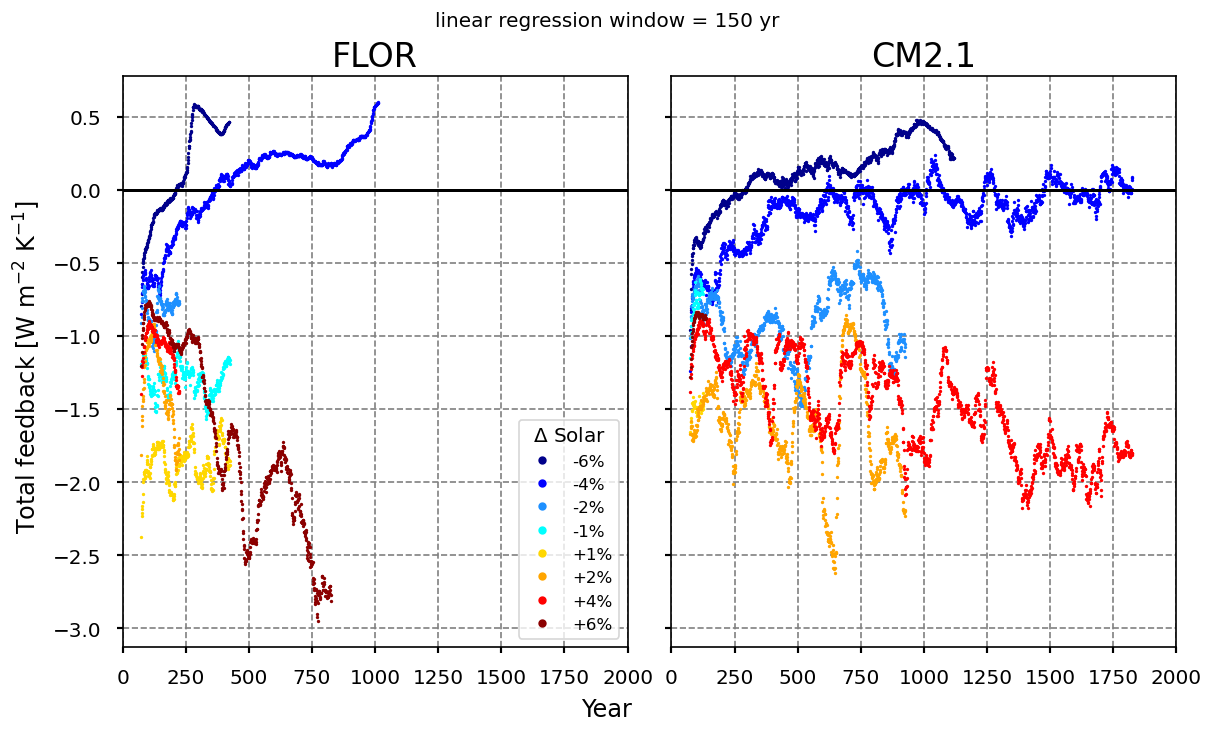

In [19]:
ref = '50yr'
window_size = 150

experiments = ['-6','-4','-2','-1','+1','+2','+4','+6']
colors = ['darkblue','blue','dodgerblue','cyan','gold','orange','red','darkred']

fig, ax = plt.subplots(1,2,figsize=(10,6), dpi=120, sharex=True, sharey=True)

models = ['FLOR','CM2.1p1']

for imodel in range(np.size(models)):

    for iexp in range(np.size(experiments)):
    
        exp = experiments[iexp]

        try:
            total_feedback = xr.open_dataarray(f'./total_feedback/total_feedback_{models[imodel]}_{exp}%solar_ref_{ref}_window_{window_size}.nc')
        except FileNotFoundError as e:
            print(f'no file found for {models[imodel]} {exp}')
            continue
        
        # plot -- constant rh decomposition
        # 150-year window, shifting reference period (50 years, every 5 years)
        
        # centered on window (x-axis)
        ax[imodel].plot(total_feedback.year-101,total_feedback, linestyle='None', marker = '.', markersize=2,
                      label=f'{exp}%',
                        #label=f'{exp}% ({total_feedback.year.size+window_size-1})',
                        color=colors[iexp])
        ax[imodel].set_title(models[imodel])
        
        ax[imodel].set_xlabel('')
        ax[imodel].set_ylabel('')
        ax[imodel].axhline(0,color='k',linewidth=1.5)
        ax[imodel].grid('--')
        legend = ax[0].legend(title=r'$\Delta$ Solar',fontsize=10, markerscale=4,loc='lower right') # makes the legend markers bigger
        ax[imodel].set_xlim(0,2000)

ax[1].set_title('CM2.1')
fig.supxlabel('Year')
fig.supylabel(r'Total feedback [W m$^{-2}$ K$^{-1}$]')
fig.suptitle(f'linear regression window = {window_size} yr',fontsize=12)

plt.savefig('Figure2.pdf',dpi=300)

# Previous: Compare multiple calculations

In [7]:
exp = '-6'

FLOR_50yr_100 = xr.open_dataarray(f'./total_feedback/total_feedback_FLOR_{exp}%solar_ref_50yr_window_100.nc')
CM21_50yr_100 = xr.open_dataarray(f'./total_feedback/total_feedback_CM2.1p1_{exp}%solar_ref_50yr_window_100.nc')

FLOR_50yr_150 = xr.open_dataarray(f'./total_feedback/total_feedback_FLOR_{exp}%solar_ref_50yr_window_150.nc')
CM21_50yr_150 = xr.open_dataarray(f'./total_feedback/total_feedback_CM2.1p1_{exp}%solar_ref_50yr_window_150.nc')

FLOR_50yr_200 = xr.open_dataarray(f'./total_feedback/total_feedback_FLOR_{exp}%solar_ref_50yr_window_200.nc')
CM21_50yr_200 = xr.open_dataarray(f'./total_feedback/total_feedback_CM2.1p1_{exp}%solar_ref_50yr_window_200.nc')

#FLOR_12month_100 = xr.open_dataarray(f'./total_feedback/total_feedback_FLOR_ref_12month_window_100.nc')
#CM21_12month_100 = xr.open_dataarray(f'./total_feedback/total_feedback_CM2.1p1_ref_12month_window_100.nc')

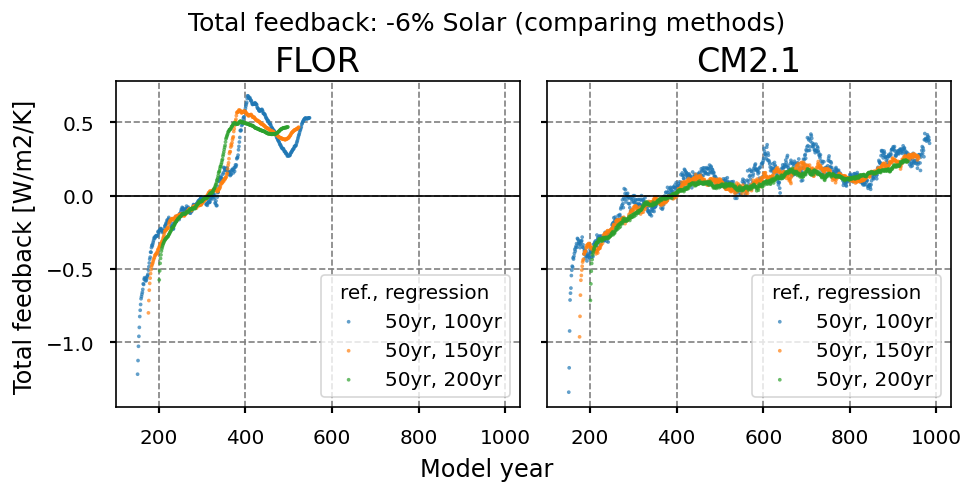

In [8]:
# plot -- constant rh decomposition
# 100-year window, shifting reference period (50 years, every 5 years)

fig, ax = plt.subplots(1,2,figsize=(8,4), dpi=120, sharex=True, sharey=True)

alpha = 0.7
    
FLOR_50yr_100.plot.scatter(ax=ax[0], marker='.', s=20, label='50yr, 100yr', edgecolor='none',alpha=alpha)
#FLOR_12month_100.plot.scatter(ax=ax[0], marker='.', s=20, label='STD, 100yr', edgecolor='none',alpha=alpha)
FLOR_50yr_150.plot.scatter(ax=ax[0], marker='.', s=20, label='50yr, 150yr', edgecolor='none',alpha=alpha)
FLOR_50yr_200.plot.scatter(ax=ax[0], marker='.', s=20, label='50yr, 200yr', edgecolor='none',alpha=alpha)
ax[0].set_title('FLOR')

CM21_50yr_100.plot.scatter(ax=ax[1], marker='.', s=20, label='50yr, 100yr', edgecolor='none',alpha=alpha)
#CM21_12month_100.plot.scatter(ax=ax[1], marker='.', s=20, label='STD, 100yr', edgecolor='none',alpha=alpha)
CM21_50yr_150.plot.scatter(ax=ax[1], marker='.', s=20, label='50yr, 150yr', edgecolor='none',alpha=alpha)
CM21_50yr_200.plot.scatter(ax=ax[1], marker='.', s=20, label='50yr, 200yr', edgecolor='none',alpha=alpha)
ax[1].set_title('CM2.1')

fig.supxlabel('Model year')
fig.supylabel('Total feedback [W/m2/K]')
fig.suptitle(f'Total feedback: -6% Solar (comparing methods)', fontsize=15)

for ii in range(2):
    ax[ii].set_xlabel('')
    ax[ii].set_ylabel('')
    ax[ii].axhline(0,color='k',linewidth=1)
    ax[ii].grid()
    ax[ii].legend(title = 'ref., regression')
    ax[ii].set_xlim(100,1033)